In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]


Total samples: 200
Correct predictions: 141
Accuracy: 70.50%


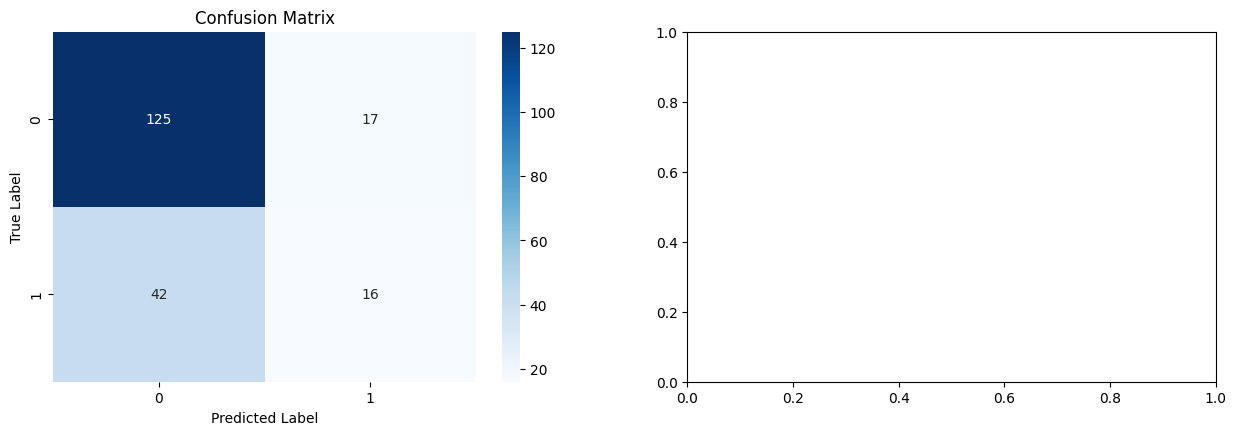

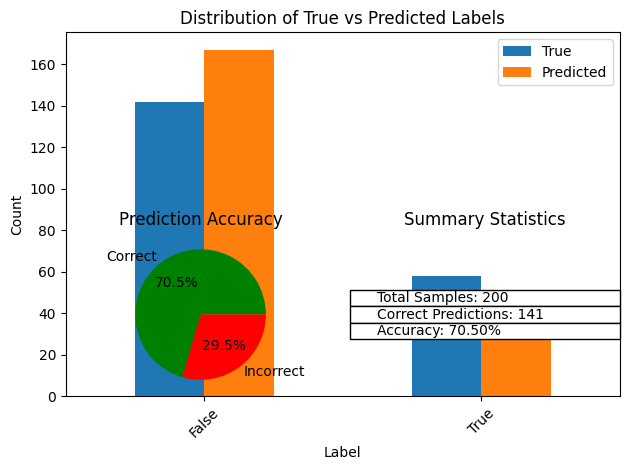


All Predictions:

Sample 1:
Text: Probably less than 4 percent of Wisconsin residents are enjoying the subsidies from Obamacare.
True Label: True
Predicted Label: False
Correct: False
----------------------------------------------------------------------------------------------------

Sample 2:
Text: Says Connie Mack takes two homestead exemptions, directly contrary to Floridas Constitution.
True Label: False
Predicted Label: False
Correct: True
----------------------------------------------------------------------------------------------------

Sample 3:
Text: Not one tax has been raised since Ive been governor.
True Label: False
Predicted Label: True
Correct: False
----------------------------------------------------------------------------------------------------

Sample 4:
Text: Under last years health care reform, a bunch of bureaucrats decide whether you get care, such as continuing on dialysis or cancer chemotherapy.
True Label: False
Predicted Label: False
Correct: True
------

In [2]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def sample_and_predict_with_visualization(file_path, model_path, n_samples=200):
    # Load dataset
    df = pd.read_csv(file_path)

    # Sample n_samples randomly from the dataset
    sampled_df = df.sample(n=n_samples, random_state=42)

    # Create label mapping
    label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
    reverse_mapping = {v: k for k, v in label_mapping.items()}

    # Initialize tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
    model = BertForSequenceClassification.from_pretrained(model_path)

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # Lists to store results
    predictions = []
    texts = []
    true_labels = []

    # Process each sample
    for idx, row in sampled_df.iterrows():
        text = str(row['text'])
        true_label = row['label']

        # Tokenize
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Move to device
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Get prediction
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = outputs.logits.argmax(dim=-1).cpu().numpy()[0]
            predicted_label = reverse_mapping[pred]

        predictions.append(predicted_label)
        texts.append(text)
        true_labels.append(true_label)

    # Create results dataframe
    results_df = pd.DataFrame({
        'Text': texts,
        'True Label': true_labels,
        'Predicted Label': predictions,
        'Correct': [t == p for t, p in zip(true_labels, predictions)]
    })

    # Print summary statistics
    print(f"\nTotal samples: {len(results_df)}")
    print(f"Correct predictions: {sum(results_df['Correct'])}")
    print(f"Accuracy: {sum(results_df['Correct']) / len(results_df):.2%}")

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # 1. Confusion Matrix
    plt.subplot(2, 2, 1)
    cm = confusion_matrix(results_df['True Label'], results_df['Predicted Label'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # 2. Distribution of True vs Predicted Labels
    plt.subplot(2, 2, 2)
    label_counts = pd.DataFrame({
        'True': results_df['True Label'].value_counts(),
        'Predicted': results_df['Predicted Label'].value_counts()
    }).fillna(0)
    label_counts.plot(kind='bar')
    plt.title('Distribution of True vs Predicted Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # 3. Accuracy Pie Chart
    plt.subplot(2, 2, 3)
    accuracy_data = results_df['Correct'].value_counts()
    plt.pie(accuracy_data, labels=['Correct', 'Incorrect'], autopct='%1.1f%%', colors=['green', 'red'])
    plt.title('Prediction Accuracy')

    # 4. Results Table
    plt.subplot(2, 2, 4)
    plt.axis('off')
    cell_text = [
        [f"Total Samples: {len(results_df)}"],
        [f"Correct Predictions: {sum(results_df['Correct'])}"],
        [f"Accuracy: {sum(results_df['Correct']) / len(results_df):.2%}"]
    ]
    plt.table(cellText=cell_text, loc='center', cellLoc='left')
    plt.title('Summary Statistics')

    plt.tight_layout()
    plt.show()

    # Print all results
    print("\nAll Predictions:")
    print("=" * 100)
    for idx, row in results_df.iterrows():
        print(f"\nSample {idx + 1}:")
        print(f"Text: {row['Text']}")
        print(f"True Label: {row['True Label']}")
        print(f"Predicted Label: {row['Predicted Label']}")
        print(f"Correct: {row['Correct']}")
        print("-" * 100)

    return results_df

# Example usage
file_path = "/content/drive/MyDrive/ProjectFilesForml/LogicalFallacyDetection/binary_data.csv"#https://drive.google.com/file/d/1SEsGK0id2m_EdmAGYZdYVOXUAqTVRDuw/view?usp=share_link
model_path = "/content/drive/MyDrive/ProjectFilesForml/best_bert_model_binary"#https://drive.google.com/drive/folders/1PBiCaN95QshFjEE_davZcAKi-FtVbMa4?usp=share_link
results = sample_and_predict_with_visualization(file_path, model_path, n_samples=200)
